---
title: "Policy Responses to a Coronavirus Pandemic"
bibliography: "../memos.bib"
author: "Peter Amerkhanian"
date: "2021-12-15"
title-block-banner: false
image: thumbnail.png
abstract: "I analyze the effects of lockdown and vaccination policies during a Coronavirus pandemic using an SIR ordinary differential equations modeling approach."
format:
  html:
    code-tools:
      source: https://github.com/peter-amerkhanian/peter-amerkhanian.github.io
      toggle: false
      caption: "Memo Code"
    echo: false
    toc: true
    toc-depth: 3
editor: 
  markdown: 
    wrap: 72
---

In [21]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown as md


# The Policy Problem
During the COVID-19 pandemic, policy makers around the world have developed a variety of tools for combating the virus: lockdowns and strategic re-openings, testing, contact-tracing,  masking, and vaccination, to name a few [@brooks_hammer_2020]. In this memo, I will examine the effectiveness of lockdowns and vaccination specifically, with an eye towards how they might be used during future pandemics. I find that lockdowns are an effective pandemic response in so far as they considerably reduce infections. I also find that a vaccine that provides temporary immunity cannot effectively end a pandemic with only one vaccination campaign. During future pandemics, policy makers should be ready to institute lockdowns, especially early in the pandemic, and prepare the public for yearly vaccine boosters once a vaccine has been developed.

# The Simple SIR Model
In order to model various pandemic responses, I implement an altered version of a simple "SIR" model - *Susceptible–Infectious–Recovered* - as defined in [@bird_simple_2020]. I adapt the SIR model to include a number of specific characteristics of the COVID-19 pandemic: diminishing immunity for those who have recovered from the virus, policy responses in the form of limited-length lock-downs with diminishing effectiveness, and the eventual introduction of a vaccination campaign. The key features of the model are defined as follows.

## Groups, Parameters, and Assumptions
There are three population groups: there is a total population, to be expressed as $1$, and on any given day, $t$, there is a percentage of individuals in the population who are susceptible to the disease - $S_t$ - a percentage of individuals currently infected - $I_t$, and a percentage of individuals who have been infected, recovered, and cannot be infected again - $R_t$. Those three groups represent the entire population:
$$ 1 = S_t + I_t + R_t $$

Along with the groups, there are three key parameters that describe the behavior of the virus in our population:

1. $\beta$ describes the growth in infections each day.[^1]
2. $\nu$ is the percentage of the infected population that recovers each day
3. $\lambda$ is the percentage of the recovered population that loses their immunity each day (vaccinated or previously infected)  

Using these population groups and the key parameters, $\beta$, $\nu$, and $\lambda$, I produce the following basic model.

[^1]: The *reproduction rate*, $\beta$, is the product of the number of interactions between infected individuals and susceptible individuals each day and the percentage of those interactions that will result in disease transmission.

## The Basic Model
On a given day, the number of infected individuals is defined as follows:
$$
\begin{align*}
\text{Infected Today} &= \text{Infected Yesterday} + \text{New Infected Today} - \text{New Recovered Today} \\
I_t &= (I_{t-1}) + (I_{t-1} \beta S_{t-1}) - (I_{t-1} \nu)
\end{align*}
$$

The number of people who have recovered from the virus and thus have temporary immunity is:
$$
\begin{align*}
\text{Recovered Today} &= \text{Recovered Yesterday} + \text{New Recovered Today} - \text{New Susceptible Today}\\
R_t &= (R_{t-1}) + (I_{t-1} \nu) - (R_{t-1} \lambda)
\end{align*}
$$

The number of individuals susceptible to the virus is those who are not infected or recovered:
$$
\begin{align*}
S_t &= 1 - I_t - R_t
\end{align*}
$$

### Assumptions
This model starts with 0.00001% of the population infected. I assume that individuals interact with an average of 10 other people each day, and 2% of those interactions result in virus transmission. Once infected, there is an average recovery time of 10 days. Those who have recovered from infection are expected to retain their immunity for 6 months on average.

## Possible Policy Responses
Lockdowns can be implemented by the government, but to have their costs reflected in the model, they can be sustained for no more than three weeks. They have the effect of reducing contacts between individuals by 75%, but have diminishing effectiveness. Each subsequent lockdown is half as effective as the previous one (the first lockdown reduces the contact rate from 10 to 2.5, the second from 10 to 5, the third from 10 to 7.5), though there is a minimum effectiveness, where no matter what number lockdown the sociey is on, there will at least be a 20% reduction in contact under lockdown. Lockdowns will be declared whenever the infected population grows beyond some threshold.

I apply the model to two distinct scenarios under which rolling lockdowns are implemented: one where no vaccine is ever developed to combat the virus and one where a vaccine is developed after one year and rolled out incrementally.  

# Scenario 1: Lockdowns, No Vaccination
The first scenario I examine is the use of rolling lockdowns, motivated by infections growing beyond a 5% threshold. In this scenario a vaccine is never developed, so lockdowns are essentially the only tool available to policy makers.

In [22]:
def SIR_dataframe(infected, reproduction_rate, susceptible, periods):
    """Create the Dataframe that will hold the SIR model results"""
    reproduction_rate = contact_rate * infection_probability
    susceptible = 1 - infected
    df_simple_SIR = pd.DataFrame(
        columns=["date", "Susceptible", "Infected", "Recovered"]
    )
    df_simple_SIR["date"] = pd.date_range(
        start=datetime(2020, 3, 1), periods=periods, freq="D", name="Date"
    )
    df_simple_SIR.iloc[0, 1:] = np.array([susceptible, infected, 0])
    return df_simple_SIR

def SIR_update(
    df_simple_SIR,
    i,
    reproduction_rate,
    recovery_probability,
    immunity_loss_probability,
    vaccination_rollout,
    total_vaccinated
):
    """Daily updater for S, I and R"""
    ### Infected
    infected_yesterday = df_simple_SIR.loc[i - 1, "Infected"]
    susceptible_yesterday = df_simple_SIR.loc[i - 1, "Susceptible"]
    newly_infected = (
        infected_yesterday
        * reproduction_rate
        * susceptible_yesterday
    )
    newly_recovered_today = df_simple_SIR.loc[i - 1, "Infected"] * recovery_probability
    # Define Infected
    df_simple_SIR.loc[i, "Infected"] = (
        infected_yesterday + newly_infected - newly_recovered_today
    )
    ### Recovered
    recovered_yesterday = df_simple_SIR.loc[i - 1, "Recovered"]
    newly_recovered_today = df_simple_SIR.loc[i - 1, "Infected"] * recovery_probability
    newly_susceptible_today = (
        df_simple_SIR.loc[i - 1, "Recovered"] * immunity_loss_probability
    )
    if vaccination_rollout and i > time_vax and total_vaccinated<=.99:
        newly_vaccinated = df_simple_SIR.loc[i - 1, "Susceptible"] * vaccination_rollout
        total_vaccinated += newly_vaccinated
    else:
        newly_vaccinated = 0
    # Define Recovered
    df_simple_SIR.loc[i, "Recovered"] = (
        recovered_yesterday
        + newly_recovered_today
        + newly_vaccinated
        - newly_susceptible_today
    )
    ### Susceptible
    infected_today = df_simple_SIR.loc[i, "Infected"]
    recovered_today = df_simple_SIR.loc[i, "Recovered"]
    # Define Susceptible
    df_simple_SIR.loc[i, "Susceptible"] = 1 - infected_today - recovered_today
    return df_simple_SIR, total_vaccinated


def SIR_model(
    infected,
    recovery_probability,
    contact_rate,
    infection_probability,
    immunity_loss_probability,
    lockdown_threshold=1,
    open_threshold=0,
    vaccination_rollout=None,
    periods=271,
    output=False,
):
    """Implements the full SIR model workflow, returns a filled in Pandas DataFrame"""
    reproduction_rate = contact_rate * infection_probability
    susceptible = 1 - infected
    df_simple_SIR = SIR_dataframe(infected, reproduction_rate, susceptible, periods)
    lockdown = False
    lockdown_counter = 0
    lockdown_timer = 0
    new_contact_rate = contact_rate
    total_vaccinated = 0
    for i in range(1, len(df_simple_SIR)):
        df_simple_SIR, total_vaccinated = SIR_update(
            df_simple_SIR,
            i,
            reproduction_rate,
            recovery_probability,
            immunity_loss_probability,
            vaccination_rollout,
            total_vaccinated
        )
        infection_over_thresh = df_simple_SIR.loc[i, "Infected"] > lockdown_threshold
        if output:
            print(
                new_contact_rate,
                lockdown,
                df_simple_SIR.loc[i, "Infected"],
                infection_over_thresh,
                lockdown_counter,
                lockdown_timer,
                total_vaccinated
            )
        if infection_over_thresh and not lockdown:
            lockdown = True
            lockdown_counter += 1
            new_contact_rate = new_contact_rate * (0.25 * lockdown_counter)
            if new_contact_rate > (contact_rate - contact_rate * 0.2):
                new_contact_rate = contact_rate - contact_rate * 0.2
            reproduction_rate = new_contact_rate * infection_probability
        elif lockdown:
            if lockdown_timer == 21:
                lockdown_start = None
                lockdown = False
                lockdown_timer = 0
                new_contact_rate = contact_rate
                reproduction_rate = new_contact_rate * infection_probability
            else:
                lockdown_timer += 1
    df_simple_SIR = df_simple_SIR.set_index("date")
    return df_simple_SIR

In [23]:
contact_rate = 10
infection_probability = 0.02
recovery_probability = 1 / 10  # Recover in 10 days
infected = 0.0000001
immunity_loss_probability = 1 / (365 / 2)  # Lose immunity in 6 months
lockdown_threshold = 0.05  # Lockdown when 5% are infected
open_threshold = 0.01  # Open if it goes down to 1%
periods = 365 * 4

time_vax = 360  # If there is a vaccine, this is how long it takes to be developed

In [24]:
df_simple_SIR = SIR_model(
    infected=infected,
    recovery_probability=recovery_probability,
    contact_rate=contact_rate,
    infection_probability=infection_probability,
    immunity_loss_probability=immunity_loss_probability,
    lockdown_threshold=lockdown_threshold,
    open_threshold=open_threshold,
    vaccination_rollout=None,
    periods=periods,
    output=False,
)

In [25]:
def plot_SIR(df_simple_SIR, title, threshold=True):
    sns.set()
    # sns.set_context("talk")
    # sns.set(font_scale=1.6)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False, sharex=True)
    fig.suptitle(title, y=1.05)
    df_simple_SIR[["Infected"]].plot(ax=axes[0])
    axes[0].set_title("Infections over Time")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Proportion of $N$")
    axes[0].tick_params(axis="x", rotation=45)
    if threshold:
        axes[0].axhline(
            lockdown_threshold,
            c="red",
            linestyle="--",
            alpha=0.5,
            label=f"Threshold for Lockdown Start: {lockdown_threshold}",
        )
    axes[0].legend()
    df_simple_SIR[["Infected", "Susceptible", "Recovered"]].plot.area(ax=axes[1])
    axes[1].set_title("Susceptible, Infected, and Recovered Population over Time")
    axes[1].set_xlabel("Date")
    axes[1].set_ylim(0, 1)
    axes[1].tick_params(axis="x", rotation=45)
    axes[1].legend()

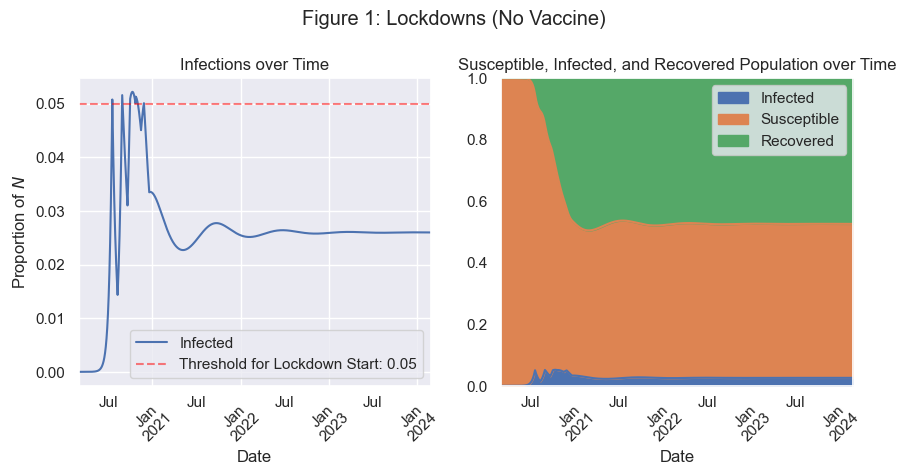

In [26]:
plot_SIR(df_simple_SIR, "Figure 1: Lockdowns (No Vaccine)")

**Figure 1** shows the outcome of this scenario. As infection transmission passes the threshold, the government calls for a lockdown, which promptly reduces infections. However, transmission has enough momentum to quickly grow again, triggering a series of lockdowns with diminishing effect. The policy does largely keep the infected population below 5%, and after the initial wave of infections subside the government doesn't have to call for any more lockdowns. The population experiences a much smaller second wave before the pandemic settles into a sort of equilibrium. About 2.5% of the population stays infected as different individuals contract the disease, recover, gain immunity, and slowly lose that immunity. This equilibrium is unfortunate - the pandemic doesn't really end in this scenario. However, this strategy is effective, and we can see that most clearly by comparing it to the alternative in which no lockdowns are instituted.

In [69]:
df_simple_SIR_no_lock = SIR_model(
    infected=infected,
    recovery_probability=recovery_probability,
    contact_rate=contact_rate,
    infection_probability=infection_probability,
    immunity_loss_probability=immunity_loss_probability,
    lockdown_threshold=1,
    open_threshold=0,
    periods=periods,
)

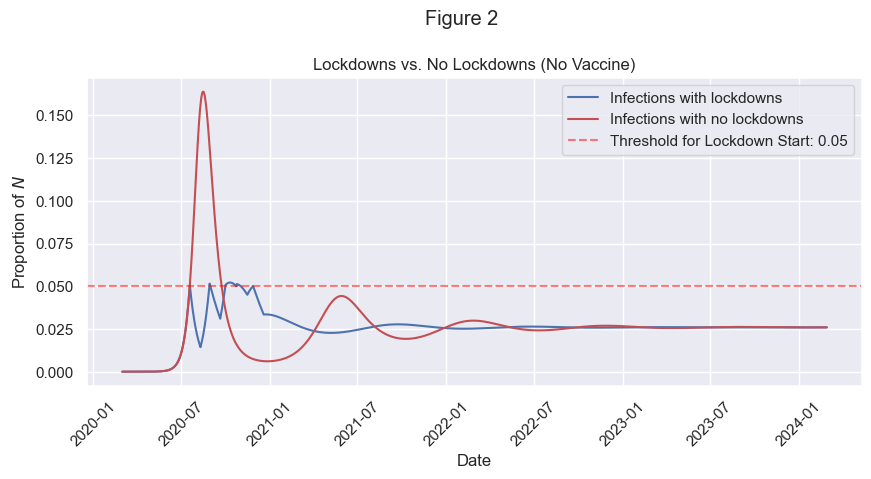

In [70]:
sns.set()
fig, axes = plt.subplots(1, 1, figsize=(10, 4), sharey=False, sharex=True)
fig.suptitle("Figure 2", y=1.05)
axes.plot(df_simple_SIR[["Infected"]], "-", c="b", label="Infections with lockdowns")
axes.plot(
    df_simple_SIR_no_lock[["Infected"]],
    "-",
    c="r",
    label="Infections with no lockdowns",
)
axes.set_title("Lockdowns vs. No Lockdowns (No Vaccine)")
axes.set_xlabel("Date")
axes.set_ylabel("Proportion of $N$")
axes.tick_params(axis="x", rotation=45)
axes.axhline(
    lockdown_threshold,
    c="red",
    linestyle="--",
    alpha=0.5,
    label=f"Threshold for Lockdown Start: {lockdown_threshold}",
)
axes.legend();

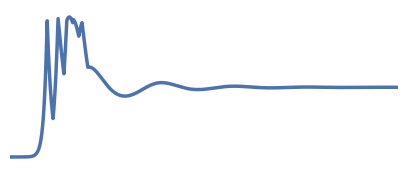

In [84]:
#| output: false
# Create a thumbnail
fig, ax = plt.subplots(figsize=(5, 2))
df_simple_SIR[["Infected"]].plot(ax=ax, linewidth=2.5)
# df_simple_SIR_no_lock[["Infected"]].plot(ax=ax, linewidth=2.5, color='darkred')
ax.legend().remove()
ax.axis('off')
fig.savefig('thumbnail.png', bbox_inches='tight', dpi=300)

In [29]:
difference = round(
    (
        (df_simple_SIR_no_lock["Infected"]).diff().clip(lower=0).sum()
        - (df_simple_SIR["Infected"]).diff().clip(lower=0).sum()
    )
    / (df_simple_SIR_no_lock["Infected"]).diff().clip(lower=0).sum(),
    2,
)
md(
f"""
**Figure 2** shows that in the absence of any lockdowns,
infections grow over 3 times as high during the first wave,
and the population later experiences
more pronounced second and third waves of infection.
One might think that lockdowns merely displace infections,
and in Figure 2 we can see a number of areas where the no-lockdowns approach has
fewer infections.
However, if we compare the sum of infections over this full time period,
we see that lockdowns lead to {int(100*difference)}% fewer infections.
"""
)


**Figure 2** shows that in the absence of any lockdowns,
infections grow over 3 times as high during the first wave,
and the population later experiences
more pronounced second and third waves of infection.
One might think that lockdowns merely displace infections,
and in Figure 2 we can see a number of areas where the no-lockdowns approach has
fewer infections.
However, if we compare the sum of infections over this full time period,
we see that lockdowns lead to 44% fewer infections.


# Scenario 2: Lockdowns, Vaccination
The second scenario I examine again involves the use of rolling lockdowns with a 5% threshold, but now a vaccine is introduced one year into the pandemic. The government's vaccination campaign is able to vaccinate 1% of the susceptible population each day and once 100% of the susceptible population is vaccinated the government ceases their campaign. Immunity through vaccination wears off after 6 months.

In [30]:
df_simple_SIR_vax_no_lock = SIR_model(
    infected=infected,
    recovery_probability=recovery_probability,
    contact_rate=contact_rate,
    infection_probability=infection_probability,
    immunity_loss_probability=immunity_loss_probability,
    lockdown_threshold=1,
    open_threshold=0,
    vaccination_rollout=0.01,
    periods=periods,
    output=False
)

In [31]:
df_simple_SIR_vax_lock = SIR_model(
    infected=infected,
    recovery_probability=recovery_probability,
    contact_rate=contact_rate,
    infection_probability=infection_probability,
    immunity_loss_probability=immunity_loss_probability,
    lockdown_threshold=lockdown_threshold,
    open_threshold=open_threshold,
    vaccination_rollout=0.01,
    periods=periods,
)

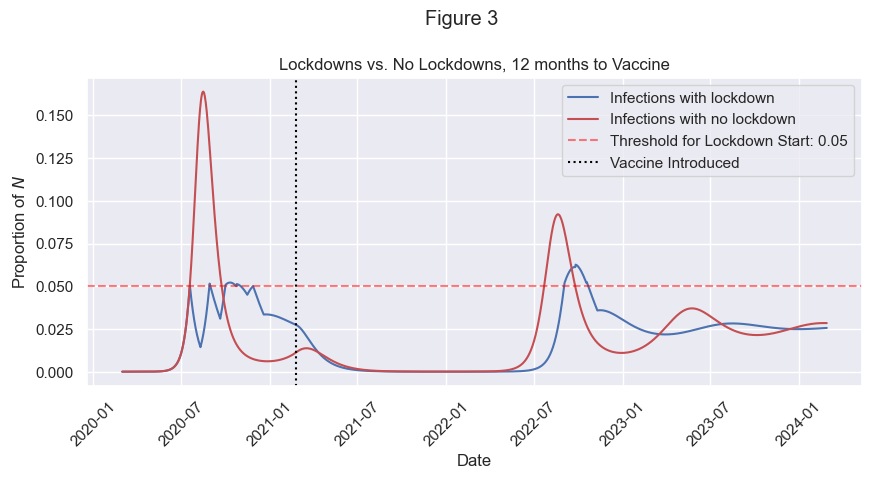

In [32]:
fig, axes = plt.subplots(1, 1, figsize=(10, 4), sharey=False, sharex=True)
fig.suptitle("Figure 3", y=1.05)
axes.plot(
    df_simple_SIR_vax_lock[["Infected"]], "-", c="b", label="Infections with lockdown"
)
axes.plot(
    df_simple_SIR_vax_no_lock[["Infected"]],
    "-",
    c="r",
    label="Infections with no lockdown",
)
axes.set_title("Lockdowns vs. No Lockdowns, 12 months to Vaccine")
axes.set_xlabel("Date")
axes.set_ylabel("Proportion of $N$")
axes.tick_params(axis="x", rotation=45)
axes.axhline(
    lockdown_threshold,
    c="red",
    linestyle="--",
    alpha=0.5,
    label=f"Threshold for Lockdown Start: {lockdown_threshold}",
)
plt.axvline(
    df_simple_SIR_vax_lock.index[time_vax],
    linestyle=":",
    c="black",
    label="Vaccine Introduced",
)
axes.legend();

**Figure 3** shows that the virus initially grows as previously shown in Figures 1 and 2, but once the vaccine is released in early 2021, the pandemic begins to subside fairly quickly. By late 2021 the pandemic is effectively over. However, vaccine immunity wears off, and given no future vaccination campaigns, there is eventually another wave of infections, This time, repeated lockdowns have diminished the intervention's effect, so infections rise to their highest point of the entire pandemic so far. After this 2022 wave infections diminish and settle into an equilibrium around 2.5%, as in previous models.

In [33]:
difference = round(
    (
        (df_simple_SIR_vax_no_lock["Infected"]).diff().clip(lower=0).sum()
        - (df_simple_SIR_vax_lock["Infected"]).diff().clip(lower=0).sum()
    )
    / (df_simple_SIR_vax_no_lock["Infected"]).diff().clip(lower=0).sum(),
    2,
)
md(
f"""
In this scenario, I find that lockdowns lead to
{int(100*difference)}% fewer new infections. This is a smaller effect than
with no vaccine, largely because with or without lockdowns the vaccine
has a large impact on reducing infections.
"""
)


In this scenario, I find that lockdowns lead to
37% fewer new infections. This is a smaller effect than
with no vaccine, largely because with or without lockdowns the vaccine
has a large impact on reducing infections.


# Policy Implications
The principal policy implication of this modeling approach is that lockdowns do a good job of preventing infections. Even only a few early lockdowns with diminishing effectiveness can make a significant dent in the total infections that occur over the course of a pandemic. This is true in cases where a vaccine eventually becomes available, and in the absence of any vaccine. The modeling approach also shows that a vaccine that provides temporary immunity ultimately cannot end the pandemic, and after immunity wears off one would expect future waves of infection. This implies that vaccine booster campaigns are essential to maintaining the positive effects of the vaccine in the longer term.